In [4]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)

np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [5]:
from IPython.display import Image
from numpy.core.umath_tests import matrix_multiply as mm

In [6]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, binom

Expectation Maximizatio (EM) Algorithm
====

- Review of Jensen's inequality
- Concavity of log function
- Example of coin tossing with missing informaiton to provide context
- Derivation of EM equations
- Illustration of EM convergence
- Derivation of update equations of coin tossing example
- Code for coin tossing example
- Derivation of update equatiosn for mixture of Gaussians
- Code for mixture of Gaussians

Jensen's inequality
----

For a convex function $f$, $E[f(x)] \geq f(E[x])$. Flip the sign for a concave function. 

A function $f(x)$ is convex if $f''(x) \geq 0$ everywhere in its domain. For example, if $f(x) = \log x$, $f''(x) = -1/x^2$, so the log function is concave for $x \in (0, \infty]$. A visual illustration of Jensen's inequality is shown below.


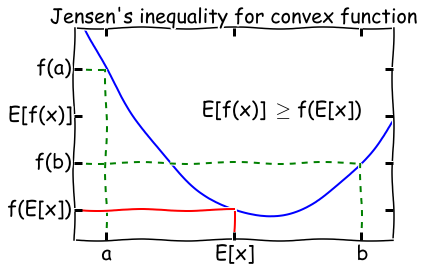

In [8]:
Image(filename='figs/jensen.png')

When is Jensen's inequality an equality? From the diagram, we can see that this only happens if the function $f(x)$ is a constant! We will make use of this fact later on in the lecture.

Maximum likelihood with complete information
----

Consider an experiment with coin $A$ that has a probability $\theta_A$ of heads, and a coin $B$ that has a probability $\theta_B$ of tails. We draw $m$ samples as follows - for each sample, pick one of the coins at random, flip it $n$ times, and record the number of heads and tails (that sum to $n$). If we recorded which coin we used for each sample, we have *complete* information and can estimate $\theta_A$ and $\theta_B$ in closed form. To be very explicit, suppose we drew 5 samples with the number of heads and tails represented as a vector $x$, and the sequence of coins chosen was $A, A, B, A, B$. Then the complete log likelihood is 

$$
\log p(x_1; \theta_A) + \log p(x_2; \theta_A) +\ log p(x_3; \theta_B) + \log p(x_4; \theta_A) +\log p(x_5; \theta_B)
$$

where $p(x_i; \theta)$ is the binomial distribtion PMF with $n=m$ and $p=\theta$. We will use $z_i$ to indicate the label of the $i^\text{th}$ coin, that is - whether we used coin $A$ or $B$ to gnerate the $i^\text{th}$ sample.

#### Coin toss example from [What is the expectation maximization algorithm?](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html)

### Solving for complete likelihood using minimization

In [5]:
def neg_loglik(thetas, n, xs, zs):
    return -np.sum([binom(n, thetas[z]).logpmf(x) for (x, z) in zip(xs, zs)])

In [6]:
m = 10
theta_A = 0.8
theta_B = 0.3
theta_0 = [theta_A, theta_B]

coin_A = bernoulli(theta_A)
coin_B = bernoulli(theta_B)

xs = map(sum, [coin_A.rvs(m), coin_A.rvs(m), coin_B.rvs(m), coin_A.rvs(m), coin_B.rvs(m)])
zs = [0, 0, 1, 0, 1]

#### Exact solution

In [7]:
xs = np.array(xs)
xs

array([7.000, 9.000, 2.000, 6.000, 0.000])

In [8]:
ml_A = np.sum(xs[[0,1,3]])/(3.0*m)
ml_B = np.sum(xs[[2,4]])/(2.0*m)
ml_A, ml_B

(0.73333333333333328, 0.10000000000000001)

#### Numerical estimate

In [9]:
bnds = [(0,1), (0,1)]
minimize(neg_loglik, [0.5, 0.5], args=(m, xs, zs), 
         bounds=bnds, method='tnc', options={'maxiter': 100})

  status: 1
 success: True
    nfev: 17
     fun: 7.6552677541393193
       x: array([0.733, 0.100])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
     jac: array([-0.000, -0.000])
     nit: 6

Incomplete information
----

However, if we did not record the coin we used, we have *missing* data and the problem of estimating $\theta$ is harder to solve. One way to approach the problem is to ask - can we assign weights $w_i$ to each sample according to how likely it is to be generated from coin $A$ or coin $B$? 

With knowledge of $w_i$, we can maximize the likelihod to find $\theta$. Similarly, given $w_i$, we can calculate what $\theta$ should be. So the basic idea behind Expectation Maximization (EM) is simply to start with a guess for $\theta$, then calculate $z$, then update $\theta$ using this new value for $z$, and repeat till convergence. The derivation below shows why the EM algorithm using this "alternating" updates actually works.

A verbal outline of the derivtion - first consider the log likelihood function as a curve (surface) where the base is $\theta$. Find another function $Q$ of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihodd function at some $\theta$ (E-step). Next find the value of $\theta$ that maximizes this function (M-step). Now find yet antoher function of $\theta$ that is a lower bound of the log-likelihood but touches the log likelihodd function at this new $\theta$. Now repeat until convergence - at this point, the maxima of the lower bound and likelihood functions are the same and we have found the maximum log likelihood. See illustratioin below. 

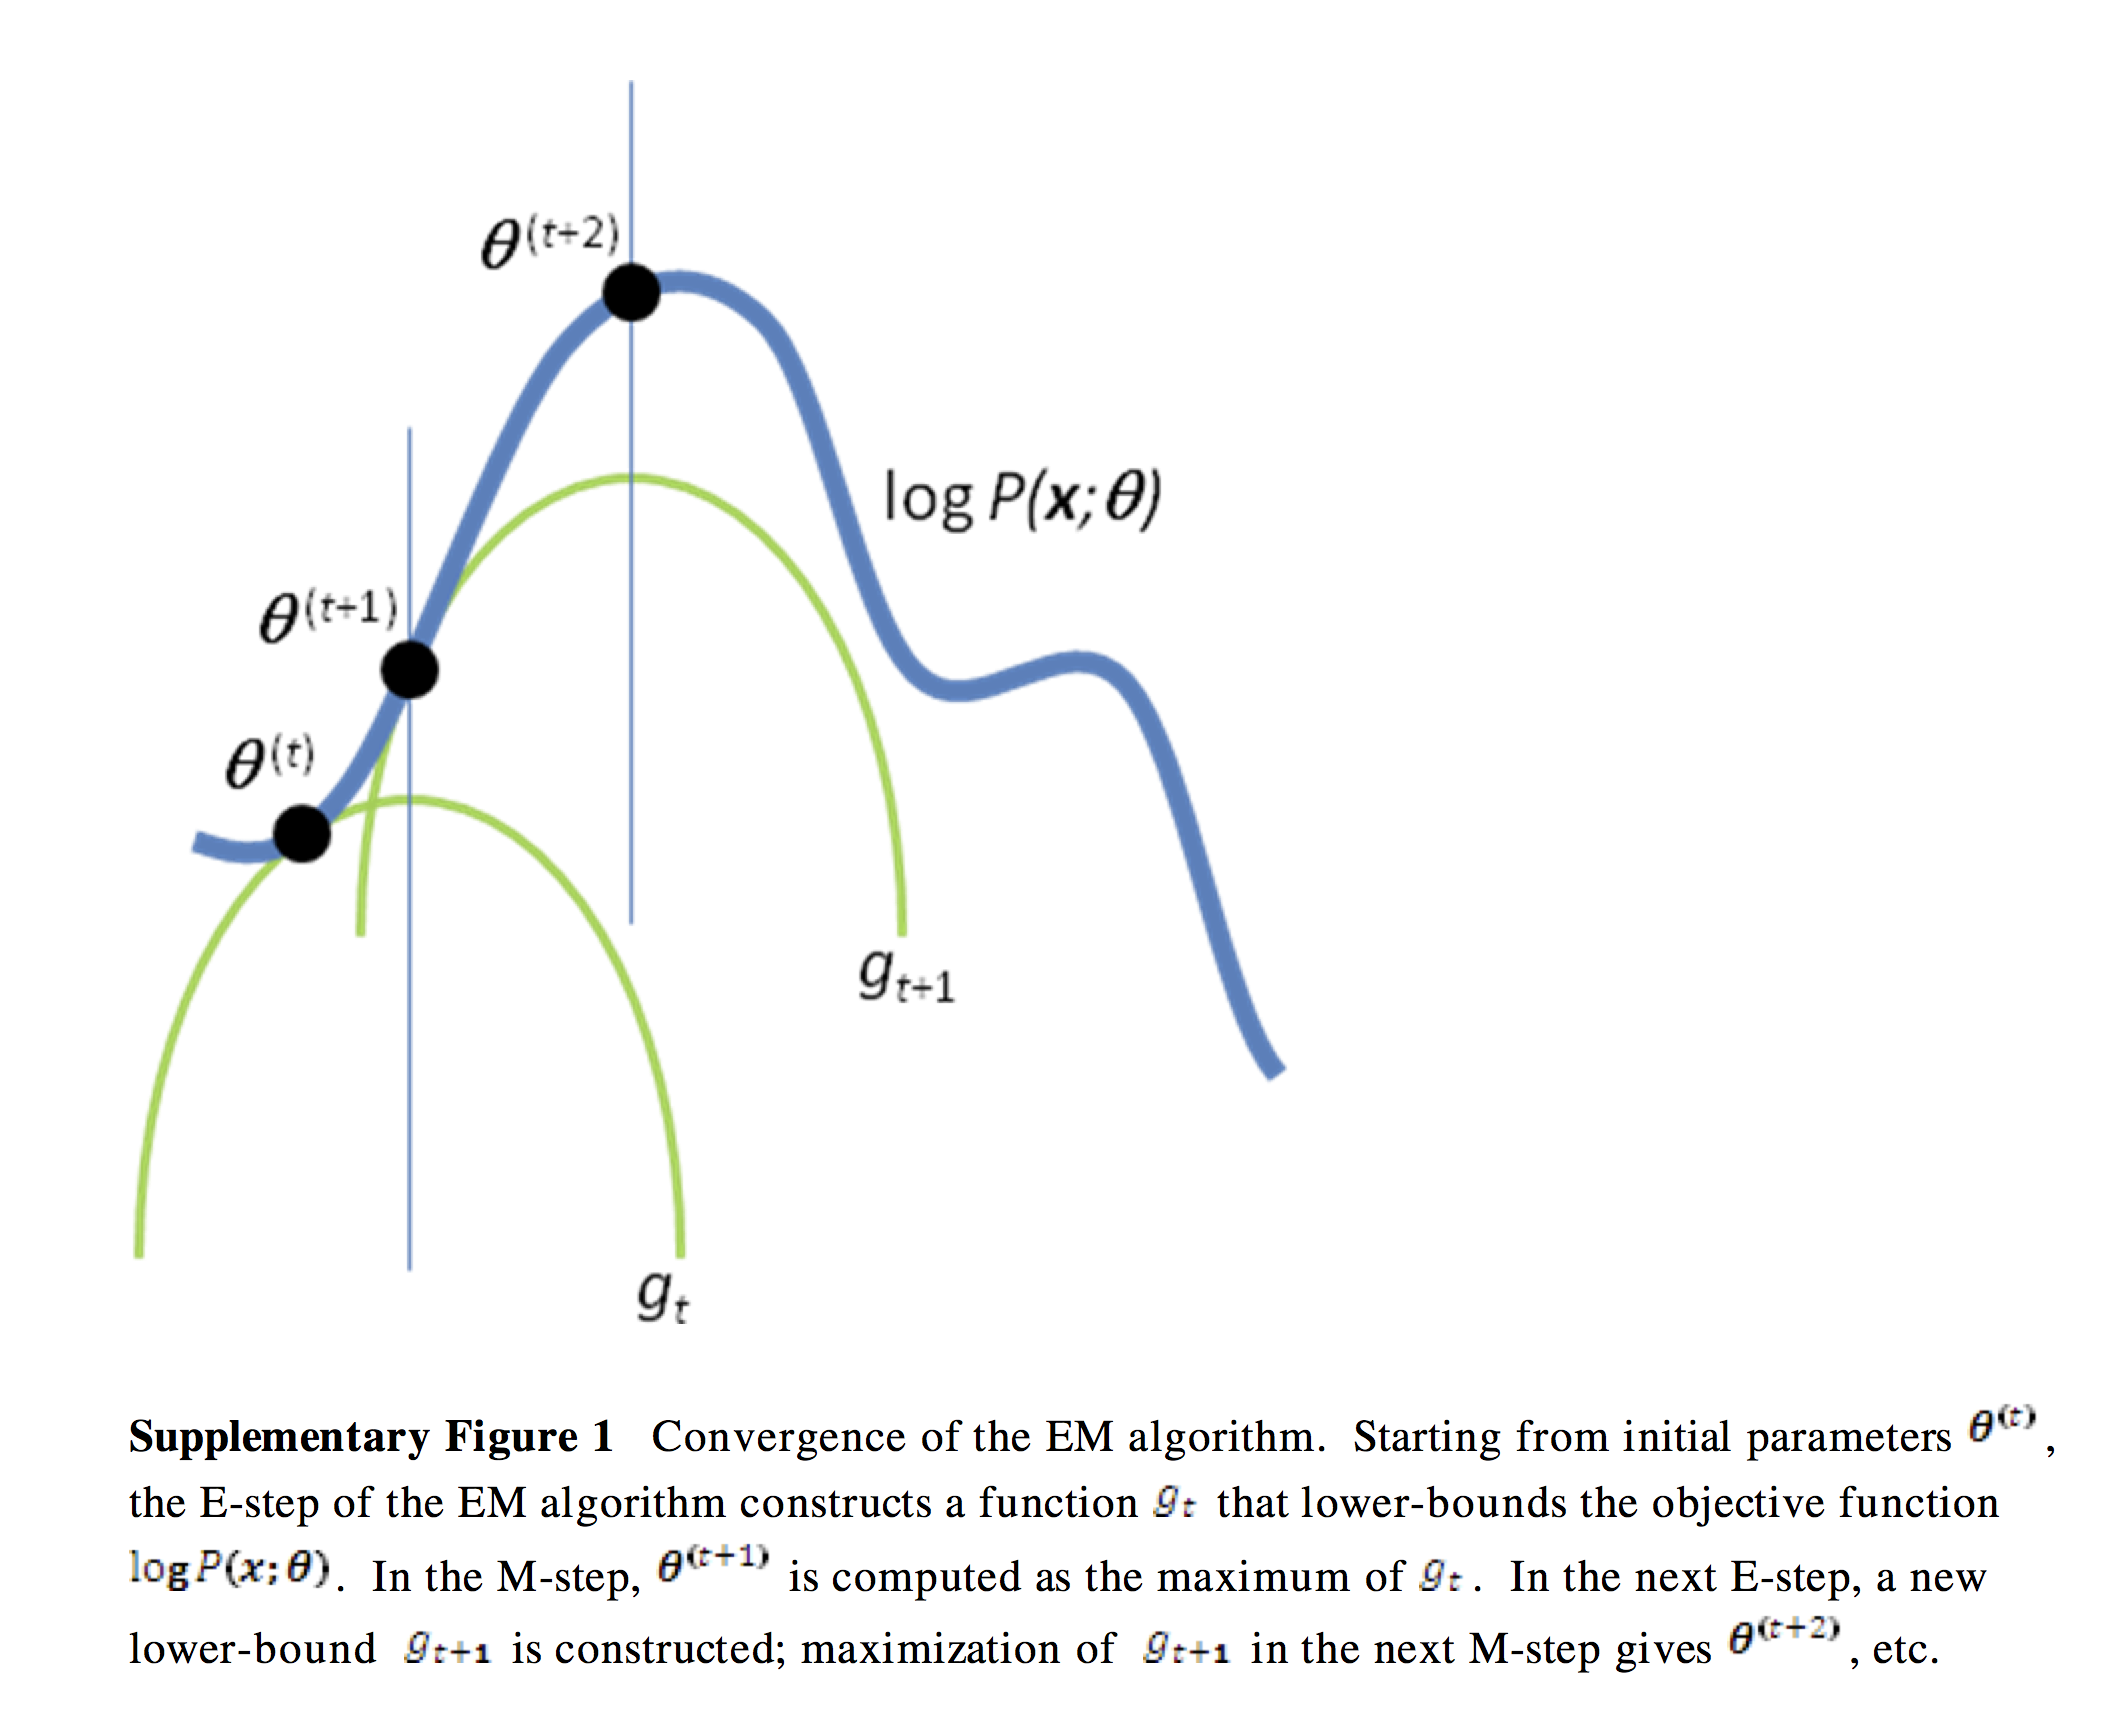

In [10]:
# Image from http://www.nature.com/nbt/journal/v26/n8/extref/nbt1406-S1.pdf
Image(filename='figs/em.png', width=800)

The only remaining step is how to find the functions that are lower bounds of the log likelihood. This will require a little math using Jensen's inequality, and is shown in the next section.

### Derivation

In the E-step, we identify a function which is a lower bound for the log-likelikelihood

\begin{align}
ll &= \sum_i{\log p(x_i; \theta)} && \text{definition of log likelihood} \\
&= \sum_i \log \sum_{z_i}{p(x_i, z_i; \theta)} && \text{augment with latent variables $z$} \\
&= \sum_i \log \sum_{z_i} Q_i(z_i) \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{$Q_i$ is a distribution for $z_i$} \\
&= \sum_i \log E_{z_i}[\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{taking expectations - hence the E in EM} \\
&\geq \sum E_{z_i}[\log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)}] && \text{Using Jensen's rule for $\log$ which is concave} \\
&\geq \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} && \text{Q function}
\end{align}

How do we choose the distribution $Q_i$? We want the Q function to touch the log-likelihood, and know that Jensen's inequality is an equality only if the function is constant. So

\begin{align}
\frac{p(x_i, z_i; \theta)}{Q_i(z_i)} =& c \\
\implies Q_i(z_i) &\propto p(x_i, z_i; \theta)\\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{\sum_{z_i}{p(x_i, z_i; \theta)}} &&\text{Since $Q$ is a distribution and sums to 1} \\
\implies Q_i(z_i) &= \frac{p(x_i, z_i; \theta) }{{p(x_i, \theta)}} && \text{marginalizing $z_i$}\\
\implies Q_i(z_i) &= p(z_i | x_i; \theta) && \text{by definition}
\end{align}

So $Q_i$ is just the posterior distribution of $z_i$, and this completes the E-step.

In the M-step, we find the value of $\theta$ that maximizes the Q function, and then we iterate over the E and M steps until convergence. 

So we see that EM is an algorihtm for maximum likelikhood optimization when there is missing inforrmaiton - or when it is useful to add latent augmented variables to simplify maximum likelihood calculatoins.

### EM for coin toss example

- $i$ indicates the sample
- $j$ indicates the coin 
- $l$ is an index running through each of the coins
- $\theta$ is the probability of the coin being heads
- $\phi$ is the probability of choosing a particular coin
- $h$ is the number of heads in a sample
- $n$ is the number of coin tosses in a sample
- $k$ is the number of coins
- $m$ is the number of samples

For the E-step, with each sample we have

\begin{align}
w_j &= Q_i(z_i = j) \\
&= p(z_i = j | x_i; \theta) \\
&= \frac{p(x_i | z_i = j; \theta) p(z_i = j; \phi)}  {\sum_{l=1}^k{p(x_i | z_i = l; \theta) p(z_i = l; \phi)}}  && \text{Baye's rule} \ P(A|B) = \frac{P(B|A) P(B)}{P(A)} \\
&= \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} \phi_l} \\
\text{[EQN 1]} &= \frac{\theta_j^h(1-\theta_j)^{n-h} }{\sum_{l=1}^k \theta_l^h(1-\theta_l)^{n-h} } && \text{assume $\phi$ is fixed since we are equally likely to choose each coin}
\end{align}

For the M-step, we need to find the value of $\theta$ that maximises the $Q$ function

\begin{align}
& \sum_i \sum_{z_i} Q_i(z_i) \log \frac{p(x_i, z_i; \theta)}{Q_i(z_i)} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{p(x_i | z_i=j; \theta) \, p(z_i = j; \phi)}{w_j} \\
&= \sum_{i=1}^m \sum_{j=1}^k w_j \log \frac{\theta_j^h(1-\theta_j)^{n-h} \phi_j}{w_j} \\
\text{[EQN 2]} &= \sum_{i=1}^m \sum_{j=1}^k w_j \left( h \log \theta_j + (n-h) \log (1-\theta_j) + \log \phi_j - \log w_j \right)
\end{align}

We can differentiate and solve for each component $\theta_s$ where the derivative vanishes

\begin{align}
\sum_{i=1}^m w_s \left( \frac{h}{\theta_s} - \frac{n-h}{1-\theta_s} \right) &= 0  \\
\implies \theta_s &= \frac {\sum_{i=1}^m w_s h}{\sum_{i=1}^m w_s n}
\end{align}


### First explicit solution

In [11]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = 0
for i in range(max_iter):
    ws_A = []
    ws_B = []
    
    vs_A = []
    vs_B = []
    
    ll_new = 0

    # E-step: calculate probability distributions over possible completions
    for x in xs:

        # multinomial (binomial) log likelihood
        ll_A = np.sum([x*np.log(thetas[0])])
        ll_B = np.sum([x*np.log(thetas[1])])
            
        # [EQN 1]
        denom = np.exp(ll_A) + np.exp(ll_B)       
        w_A = np.exp(ll_A)/denom
        w_B = np.exp(ll_B)/denom
        
        ws_A.append(w_A)
        ws_B.append(w_B)

        # used for calculating theta
        vs_A.append(np.dot(w_A, x))
        vs_B.append(np.dot(w_B, x))
        
        # update complete log likelihood
        ll_new += w_A * ll_A + w_B * ll_B
    
    # M-step: update values for parameters given current distribution
    # [EQN 2]
    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)
    # print distribution of z for each x and current parameter estimate
    
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)

    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


### Vectorizing ...

In [12]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    vs_A = w_A[:, None] * xs
    vs_B = w_B[:, None] * xs
    
    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B)
    
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)
    
    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -32.69
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -31.26
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -30.76
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -30.33
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.07
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.95
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.90
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.87


In [14]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

tol = 0.01
max_iter = 100

ll_old = -np.infty
for i in range(max_iter):
    ll_A = np.sum(xs * np.log(thetas[0]), axis=1)
    ll_B = np.sum(xs * np.log(thetas[1]), axis=1)
    denom = np.exp(ll_A) + np.exp(ll_B)
    w_A = np.exp(ll_A)/denom
    w_B = np.exp(ll_B)/denom

    vs_A = w_A[:, None] * xs
    vs_B = w_B[:, None] * xs
    
    thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
    thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)

    ll_new = w_A.dot(ll_A) + w_B.dot(ll_B) - w_A.dot(np.log(w_A)) - w_B.dot(np.log(w_B))
    
    print "Iteration: %d" % (i+1)
    print "theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new)
    
    if np.abs(ll_new - ll_old) < tol:
        break
    ll_old = ll_new

Iteration: 1
theta_A = 0.71, theta_B = 0.58, ll = -29.63
Iteration: 2
theta_A = 0.75, theta_B = 0.57, ll = -28.39
Iteration: 3
theta_A = 0.77, theta_B = 0.55, ll = -28.26
Iteration: 4
theta_A = 0.78, theta_B = 0.53, ll = -28.16
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -28.12
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -28.11
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -28.10


### Writing as a function

In [ ]:
def em(xs, thetas, max_iter=100, tol=1e-6):
    """Expectation-maximization for coin sample problem."""
    
    ll_old = -np.infty
    for i in range(max_iter):
        ll = np.array([np.sum(xs * np.log(theta), axis=1) for theta in thetas])    
        lik = np.exp(ll)
        ws = lik/lik.sum(0)
        vs = np.array([w[:, None] * xs for w in ws])
        thetas = np.array([v.sum(0)/v.sum() for v in vs])
        ll_new = np.sum([w*l for w, l in zip(ws, ll)])
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
    return i, thetas, ll_new

### Checking

In [ ]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.6, 0.4], [0.5, 0.5]])

i, thetas, ll = em(xs, thetas)
print i
for theta in thetas:
    print theta
print ll

### Make up some data

In [ ]:
np.random.seed(1234)

n = 100
p0 = 0.8
p1 = 0.35
xs = np.concatenate([np.random.binomial(n, p0, n/2), np.random.binomial(n, p1, n/2)])
xs = np.column_stack([xs, n-xs])
np.random.shuffle(xs)

### EM with multiple random starts

In [ ]:
results = [em(xs, np.random.random((2,2))) for i in range(10)]
i, thetas, ll =  sorted(results, key=lambda x: x[-1])[-1]
print i
for theta in thetas:
    print theta
print ll

Gaussian mixture models
----

In [ ]:
import scipy.stats as st

In [ ]:
def f(x, y):
    z = np.column_stack([x.ravel(), y.ravel()])
    return (0.1*st.multivariate_normal([0,0], 1*np.eye(2)).pdf(z) +
            0.4*st.multivariate_normal([3,3], 2*np.eye(2)).pdf(z) +
            0.5*st.multivariate_normal([0,5], 3*np.eye(2)).pdf(z))

In [ ]:
f(np.arange(3), np.arange(3))

In [ ]:
s = 200
x = np.linspace(-3, 6, s)
y = np.linspace(-3, 8, s)
X, Y = np.meshgrid(x, y)
Z = np.reshape(f(X, Y), (s, s))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
plt.title('Gaussian Mxixture Model');

A mixture of $k$ Gaussians has the following PDF

\begin{align}
p(x) = \sum_{j=1}^k \alpha_j \phi(x; \mu_j, \Sigma_j)
\end{align}

where $\alpha_j$ is the weight of the $j^\text{th}$ Gaussain component and 

\begin{align}
\phi(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{d/2}|\Sigma|^{1/2}} \exp \left( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \right)
\end{align}

Suppose we observe $y_1, y_2, \ldots, y_n$ as a sample from a mixture of Gaussians. The log-likeihood is then

\begin{align}
l(\theta) = \sum_{i=1}^n \log \left( \sum_{j=1}^k \alpha_j \phi(y_i; \mu_j, \Sigma_j) \right)
\end{align}

where $\theta = (\alpha, \mu, \Sigma)$

There is no closed form for maximizing the parameters of this log-likelihood, and it is hard to maximize directly.

Using EM
----

Suppose we augment with the latent variable $z$ that indicates which of the $k$ Gaussians our observation $y$ came from. The derivation of the E and M steps are the same as for the toy example, only with more algebra.

For the E-step, we have

\begin{align}
w_j^i &= Q_i(z^i = j) \\
&= p(z^i = j | y^i; \theta) \\
&= \frac{p(y^i | z^i = j; \mu, \Sigma) p(z^i = j; \alpha)}  {\sum_{l=1}^k{p(y^i | z^i = l; \mu, \Sigma) p(z^i = l; \alpha)}}  && \text{Baye's rule} \\
&= \frac{\phi(y^i; \mu_j, \Sigma_j) \alpha_j}{\sum_{l=1}^k \phi(y^i; \mu_l, \Sigma_l) \alpha_l}
\end{align}

For the M-step, we have to find $\theta = (w, \mu, \Sigma)$ that maximizes $Q$

\begin{align}
\sum_{i=1}^{m}\sum_{j=1}^{k} Q(z^i=j) \log \frac{p(x^i | z^i= j; \mu, \Sigma) p(z^i=j; \alpha)}{Q(z^i=j)}
\end{align}

By taking derivatives with respect to $(w, \mu, \Sigma)$ respectively and solving (remember to use Lagrange multipliers for the constraint that $\sum_{j=1}^k w_j = 1$), we get

\begin{align}
\alpha_j &= \frac{1}{m} \sum_{i=1}^{m} w_j^i \\
\mu_j &= \frac{\sum_{i=1}^{m} w_j^i x^i}{\sum_{i=1}^{m} w_j^i} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^i (x^i - \mu)(x^i - \mu)^T}{\sum_{i1}^{m} w_j^i}
\end{align}

In [ ]:
from scipy.stats import multivariate_normal as mvn


In [ ]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # update complete log likelihoood 
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorized version
----

In [ ]:
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Vectorization with Einstein summation notation
----

In [ ]:
def em_gmm_eins(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j, (pi, mu, sigma) in enumerate(zip(pis, mus, sigmas)):
            ws[j, :] = pi * mvn(mu, sigma).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = np.einsum('kn->k', ws)/n
        mus = np.einsum('kn,np -> kp', ws, xs)/ws.sum(1)[:, None]
        sigmas = np.einsum('kn,knp,knq -> kpq', ws, 
            xs-mus[:,None,:], xs-mus[:,None,:])/ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood 
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

Comparison of EM routines
----

In [ ]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n)) 
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [ ]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [ ]:
%%time
ll2, pis2, mus2, sigmas2 = em_gmm_vect(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis2, mus2, sigmas2):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [ ]:
%%time
ll3, pis3, mus3, sigmas3 = em_gmm_eins(xs, pis, mus, sigmas)

In [ ]:
# %timeit em_gmm_orig(xs, pis, mus, sigmas)
%timeit em_gmm_vect(xs, pis, mus, sigmas)
%timeit em_gmm_eins(xs, pis, mus, sigmas)

In [ ]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis3, mus3, sigmas3):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()